<a href="https://colab.research.google.com/github/MarcosPalacios/Recurrent-Neural-Networks-for-Electricity-Price-Prediction/blob/main/Testeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data Loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
#Removemos la columna con las horas
df = df.drop('Unnamed: 0',axis=1)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#Asignamos el 70% de los datos al train dataset
train_df = df[0:int(n*0.7)]
#Asignamos el 20% de los datos al validation dataset
val_df = df[int(n*0.7):int(n*0.9)]
#Asignamos el 20% de los datos al test dataset
test_df = df[int(n*0.9):]

#Cuantas features en total tiene nuestro data set
num_features = df.shape[1]

# **Preprocessing**

In [5]:
#Preprocesado de los datos
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
#Dropout layer para hacer feature selection

# **Data Wrangling**

In [6]:
#Clase a la que se le introducen los 3 datasets y los tamaños de nuestras ventanas

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    #Esta funcion coge los dataset que se la pasan y los convierte al formato tf.data.Dataset
    #Crea secuencias del dataset. Las secuencias se iran desplanzando de hora en hora: 1ª [1,2,3,4,5], 2º [2,3,4,5,6], 3ª [3,4,5,6,7] ...
    def make_dataset(self, data):
        data = np.array(data, dtype=float)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size, #Le pasamos el tamaño de la ventana, es decir de cuantas horas totales se ha de componer cada ventana.
          sequence_stride=1,
          shuffle=True, #Aqui se le indica si queremos que mezcle las secuencias o que mantenga el orden en que se le van pasanndo #Alberto ¿Que es mejor para modelar?
          batch_size=32) #Batch size es el tamaño de agrupamiento de las secuencias que va generando. 32 es el tamaño optimo recomendado en machine learning.

          #A priorri true para eliminar correlaciones temporales
          
        ds = ds.map(self.split_window)#Separamos el dataset en dos, inputs y labels (Xs e Ys)

        return ds

    #Esta funcion separa las variables dependientes Y de las independientes X
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='Price', max_subplots=9):

        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time [h]')

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

In [7]:
OUT_STEPS = 24

#Generamos una ventana para los datos de 168 horas (7 dias) de inputs mas 24 horas de dias para predecir
multi_window = WindowGenerator(input_width=168, label_width=24, shift=OUT_STEPS, label_columns=['Price'])

multi_window

Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['Price']

In [ ]:
print('Input shape:', multi_window.example[0].shape)
print('Label shape:', multi_window.example[1].shape)

Input shape: (32, 168, 18)
Label shape: (32, 24, 1)


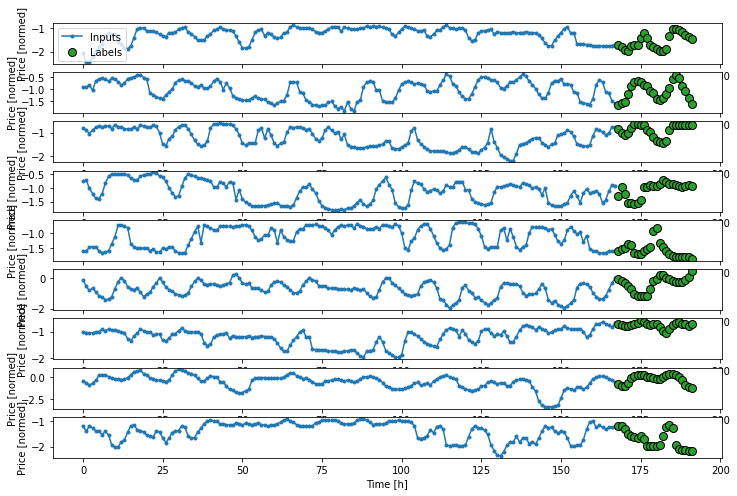

In [ ]:
multi_window.plot()

# **Modeling**

In [8]:
#Funcion que compila los modelos

def compile_and_fit(model, window, patience=2, epochs = 20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience, mode='min')

  model.compile(loss= tf.losses.MeanSquaredError(), #funcion que optimiza y la metrica
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs= MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#Funcion que plotea las curvas loss y val_loss
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [113]:
val_performance = {}
performance = {}

## Multi-step dense

In [137]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'), #parametros para jugar
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=24),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([-1, 1]),
])

In [138]:
history = compile_and_fit(multi_step_dense, multi_window)

Epoch 1/20
1145/1145 [==============================] - 8s 6ms/step - loss: 0.2588 - mean_absolute_error: 0.3721 - val_loss: 0.3384 - val_mean_absolute_error: 0.4488
Epoch 2/20
1145/1145 [==============================] - 10s 8ms/step - loss: 0.1500 - mean_absolute_error: 0.2901 - val_loss: 0.2343 - val_mean_absolute_error: 0.3730
Epoch 3/20
1145/1145 [==============================] - 11s 9ms/step - loss: 0.1268 - mean_absolute_error: 0.2678 - val_loss: 0.2565 - val_mean_absolute_error: 0.3896
Epoch 4/20
1145/1145 [==============================] - 7s 6ms/step - loss: 0.1131 - mean_absolute_error: 0.2544 - val_loss: 0.3161 - val_mean_absolute_error: 0.4323


In [139]:
multi_step_dense.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                96800     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_33 (Dense)             (None, 24)                792       
_________________________________________________________________
reshape_22 (Reshape)         (None, 24, 1)             0         
Total params: 98,648
Trainable params: 98,648
Non-trainable params: 0
_________________________________________________________________


In [140]:
multi_step_dense(multi_window.example[0]).shape

TensorShape([32, 24, 1])

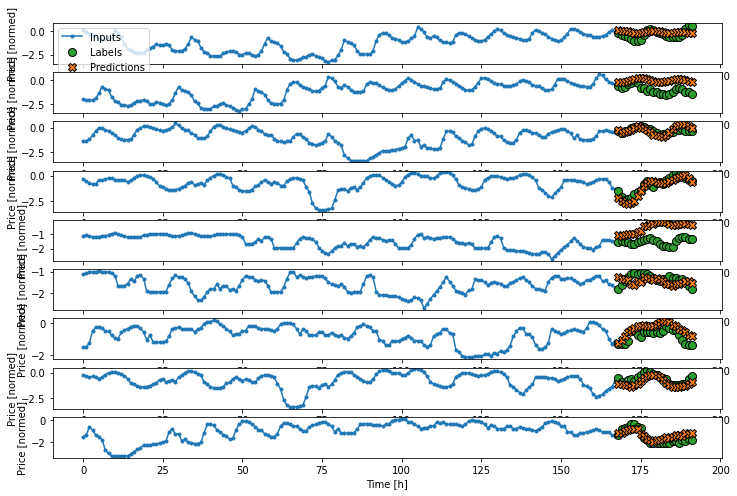

In [141]:
multi_window.plot(multi_step_dense)


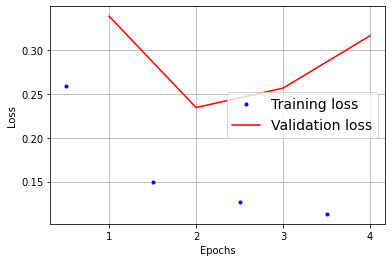

In [142]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [143]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(multi_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 1s 4ms/step - loss: 0.3161 - mean_absolute_error: 0.4323


## Single-Step CNN

In [19]:
CONV_WIDTH = 168 #Input with

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=24),
    tf.keras.layers.Reshape([-1, 1]),
])

In [20]:
history = compile_and_fit(conv_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 38s 9ms/step - loss: 0.2696 - mean_absolute_error: 0.3825 - val_loss: 0.2533 - val_mean_absolute_error: 0.3878
Epoch 2/20
1145/1145 [==============================] - 10s 9ms/step - loss: 0.1480 - mean_absolute_error: 0.2885 - val_loss: 0.2061 - val_mean_absolute_error: 0.3448
Epoch 3/20
1145/1145 [==============================] - 9s 8ms/step - loss: 0.1252 - mean_absolute_error: 0.2665 - val_loss: 0.2653 - val_mean_absolute_error: 0.3917
Epoch 4/20
1145/1145 [==============================] - 9s 7ms/step - loss: 0.1129 - mean_absolute_error: 0.2542 - val_loss: 0.2704 - val_mean_absolute_error: 0.3963


In [21]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             96800     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 24)             792       
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 1)             0         
Total params: 98,648
Trainable params: 98,648
Non-trainable params: 0
_________________________________________________________________


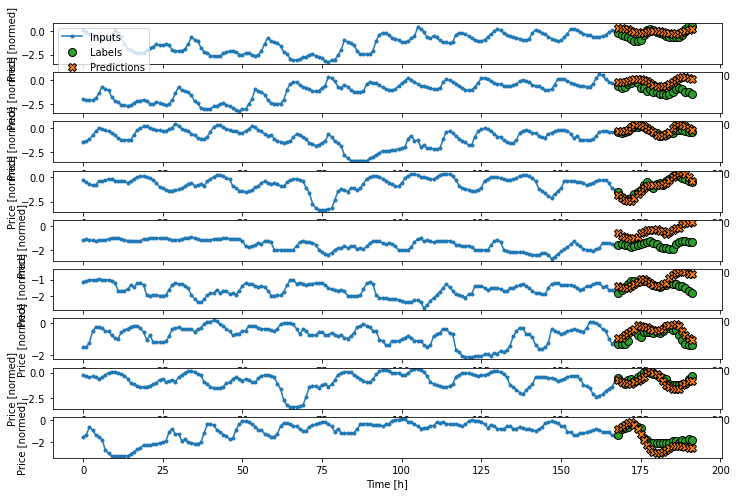

In [22]:
multi_window.plot(conv_model)

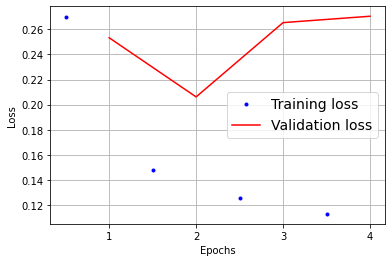

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [114]:
val_performance['CONV'] = conv_model.evaluate(multi_window.val)
performance['CONV'] = conv_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 2s 5ms/step - loss: 0.2704 - mean_absolute_error: 0.3963


## Single-step RNN

In [24]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=24),
    tf.keras.layers.Reshape([-1, 1]), 
])

In [25]:
history = compile_and_fit(lstm_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 24s 18ms/step - loss: 0.3097 - mean_absolute_error: 0.4116 - val_loss: 0.4674 - val_mean_absolute_error: 0.5319
Epoch 2/20
1145/1145 [==============================] - 17s 14ms/step - loss: 0.1678 - mean_absolute_error: 0.3030 - val_loss: 0.5091 - val_mean_absolute_error: 0.5611
Epoch 3/20
1145/1145 [==============================] - 15s 13ms/step - loss: 0.1367 - mean_absolute_error: 0.2754 - val_loss: 0.5230 - val_mean_absolute_error: 0.5749


In [26]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6528      
_________________________________________________________________
dense_5 (Dense)              (None, 24)                792       
_________________________________________________________________
reshape_2 (Reshape)          (None, 24, 1)             0         
Total params: 7,320
Trainable params: 7,320
Non-trainable params: 0
_________________________________________________________________


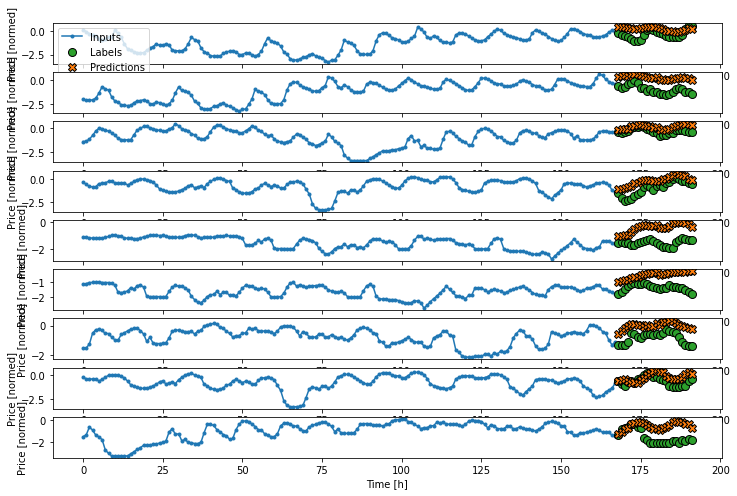

In [27]:
multi_window.plot(lstm_model)


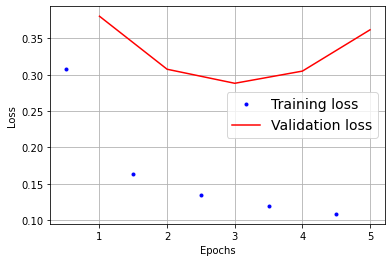

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [115]:
val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 2s 6ms/step - loss: 0.5230 - mean_absolute_error: 0.5749


## Multi-Step CNN

In [265]:
CONV_WIDTH = 168

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [266]:
history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 10s 8ms/step - loss: 0.2148 - mean_absolute_error: 0.3469 - val_loss: 0.2618 - val_mean_absolute_error: 0.3932
Epoch 2/20
1145/1145 [==============================] - 11s 9ms/step - loss: 0.1704 - mean_absolute_error: 0.3114 - val_loss: 0.2041 - val_mean_absolute_error: 0.3471
Epoch 3/20
1145/1145 [==============================] - 10s 9ms/step - loss: 0.1594 - mean_absolute_error: 0.3025 - val_loss: 0.1965 - val_mean_absolute_error: 0.3415
Epoch 4/20
1145/1145 [==============================] - 8s 7ms/step - loss: 0.1541 - mean_absolute_error: 0.2983 - val_loss: 0.2025 - val_mean_absolute_error: 0.3434
Epoch 5/20
1145/1145 [==============================] - 8s 7ms/step - loss: 0.1451 - mean_absolute_error: 0.2897 - val_loss: 0.2149 - val_mean_absolute_error: 0.3576


In [267]:
multi_conv_model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 168, 18)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1, 256)            774400    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 1, 24)             6168      
_________________________________________________________________
reshape_47 (Reshape)         (None, 24, 1)             0         
Total params: 780,568
Trainable params: 780,568
Non-trainable params: 0
_________________________________________________________________


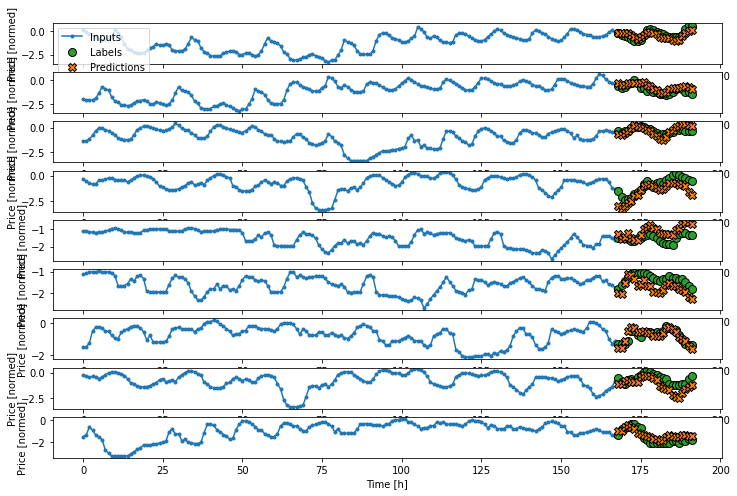

In [268]:
multi_window.plot(multi_conv_model)

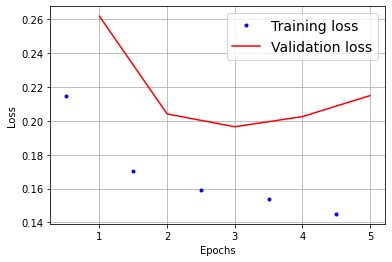

In [269]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [270]:
val_performance['MULTI_CONV'] = multi_conv_model.evaluate(multi_window.val)
performance['MULTI_CONV'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 2s 6ms/step - loss: 0.2149 - mean_absolute_error: 0.3576


## Multi-step RNN

In [215]:
multi_lstm_model = tf.keras.Sequential([
                                        
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUT_STEPS*1,
                         ),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [216]:
history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 18s 13ms/step - loss: 0.3448 - mean_absolute_error: 0.4406 - val_loss: 0.3201 - val_mean_absolute_error: 0.4312
Epoch 2/20
1145/1145 [==============================] - 14s 12ms/step - loss: 0.2062 - mean_absolute_error: 0.3395 - val_loss: 0.3270 - val_mean_absolute_error: 0.4295
Epoch 3/20
1145/1145 [==============================] - 13s 12ms/step - loss: 0.1774 - mean_absolute_error: 0.3159 - val_loss: 0.4290 - val_mean_absolute_error: 0.4870


In [217]:
multi_lstm_model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 32)                6528      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 24)                792       
_________________________________________________________________
reshape_39 (Reshape)         (None, 24, 1)             0         
Total params: 7,320
Trainable params: 7,320
Non-trainable params: 0
_________________________________________________________________


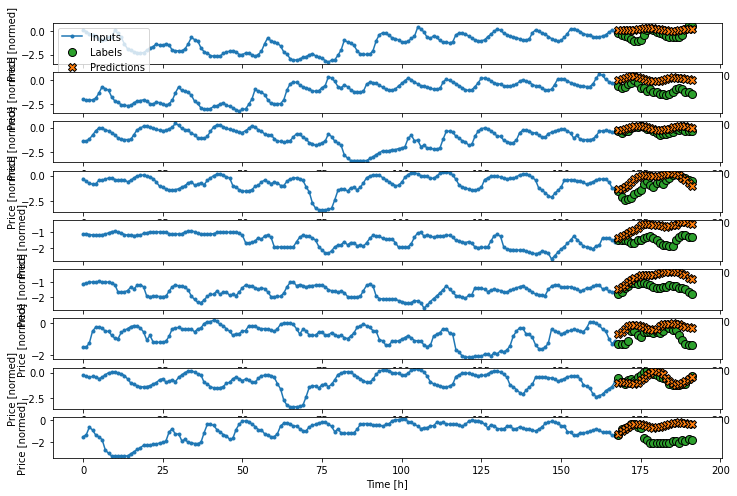

In [218]:
multi_window.plot(multi_lstm_model)

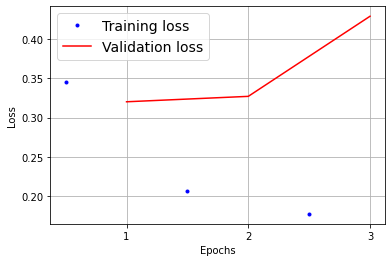

In [219]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [220]:
val_performance['MULTI_LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['MULTI_LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 2s 7ms/step - loss: 0.4290 - mean_absolute_error: 0.4870


## DEEP RNN

In [201]:
model8 = tf.keras.models.Sequential([
                               
    tf.keras.layers.LSTM(40, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(units=24,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([24, 1]),
])

In [203]:
history = compile_and_fit(model8, multi_window)

Epoch 1/20
1145/1145 [==============================] - 23s 18ms/step - loss: 0.1523 - mean_absolute_error: 0.2878 - val_loss: 0.5478 - val_mean_absolute_error: 0.5561
Epoch 2/20
1145/1145 [==============================] - 16s 14ms/step - loss: 0.0745 - mean_absolute_error: 0.2085 - val_loss: 0.5500 - val_mean_absolute_error: 0.5585
Epoch 3/20
1145/1145 [==============================] - 18s 16ms/step - loss: 0.0562 - mean_absolute_error: 0.1819 - val_loss: 0.4644 - val_mean_absolute_error: 0.5164
Epoch 4/20
1145/1145 [==============================] - 16s 14ms/step - loss: 0.0469 - mean_absolute_error: 0.1665 - val_loss: 0.4214 - val_mean_absolute_error: 0.4978
Epoch 5/20
1145/1145 [==============================] - 16s 14ms/step - loss: 0.0425 - mean_absolute_error: 0.1583 - val_loss: 0.4255 - val_mean_absolute_error: 0.5025
Epoch 6/20
1145/1145 [==============================] - 15s 13ms/step - loss: 0.0399 - mean_absolute_error: 0.1531 - val_loss: 0.4857 - val_mean_absolute_error:

In [204]:
model8.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 168, 40)           9440      
_________________________________________________________________
dropout_5 (Dropout)          (None, 168, 40)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1, 256)            1720576   
_________________________________________________________________
dense_51 (Dense)             (None, 1, 24)             6168      
_________________________________________________________________
reshape_37 (Reshape)         (None, 24, 1)             0         
Total params: 1,736,184
Trainable params: 1,736,184
Non-trainable params: 0
_________________________________________________________________


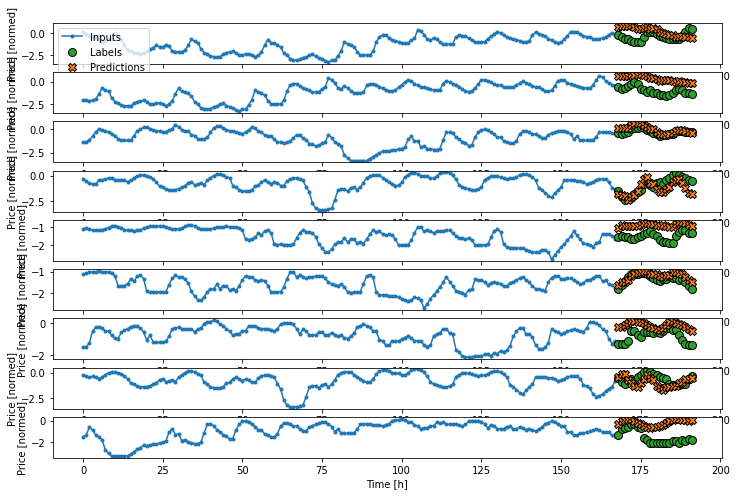

In [205]:
multi_window.plot(model8)

In [206]:
val_performance['DEEPLST'] = model8.evaluate(multi_window.val)
performance['DEEPLST'] = model8.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 3s 8ms/step - loss: 0.4857 - mean_absolute_error: 0.5399


# **Evaluation**

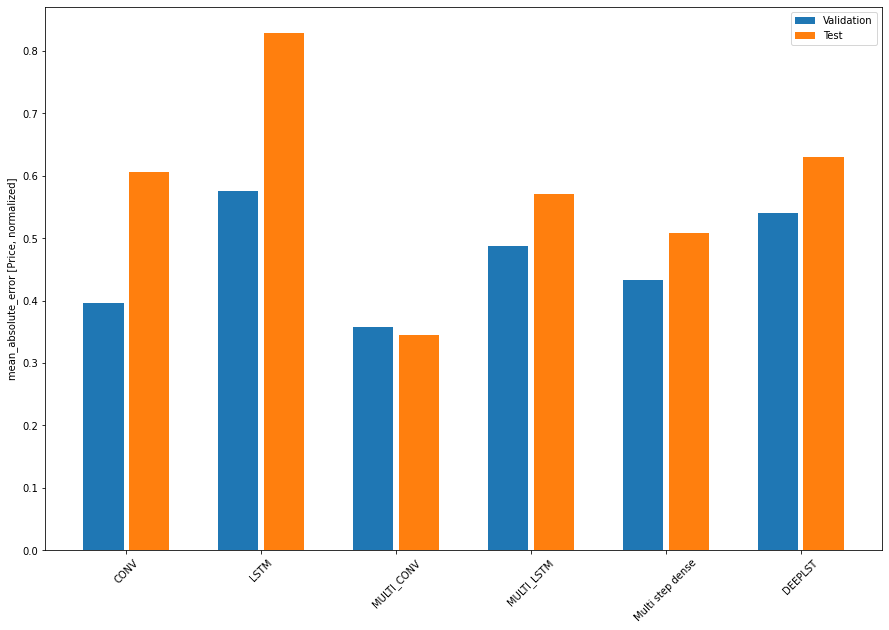

In [273]:
#Ploteamos la performance de los diferentes modelos
mpl.rcParams['figure.figsize'] = (15, 10)


x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [271]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

CONV        : 0.6055
LSTM        : 0.8290
MULTI_CONV  : 0.3454
MULTI_LSTM  : 0.5704
Multi step dense: 0.5074
DEEPLST     : 0.6301


In [263]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

CONV        : 0.6055
LSTM        : 0.8290
MULTI_CONV  : 0.3915
MULTI_LSTM  : 0.5704
Multi step dense: 0.5074
DEEPLST     : 0.6301


In [256]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

CONV        : 0.6055
LSTM        : 0.8290
MULTI_CONV  : 0.3902
MULTI_LSTM  : 0.5704
Multi step dense: 0.5074
DEEPLST     : 0.6301


In [248]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

CONV        : 0.6055
LSTM        : 0.8290
MULTI_CONV  : 0.4758
MULTI_LSTM  : 0.5704
Multi step dense: 0.5074
DEEPLST     : 0.6301


In [241]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

CONV        : 0.6055
LSTM        : 0.8290
MULTI_CONV  : 0.4302
MULTI_LSTM  : 0.5704
Multi step dense: 0.5074
DEEPLST     : 0.6301
